# Data Exploration Notebook

Goal of this notebook is just to examine tensors and stuff, determine dimensions/interpretations.

In [83]:
import torch
import pickle
import cv2
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from typing import NamedTuple
from collections import namedtuple

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose

TEST_DATA_PATH = r"D:\School\Winter 2024\CSE 517\project\data-expanded\general-conference-october-2023-general-conference-2023-10-1010-david-a-bednar-1080p-ase.pickle"

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Load data into pytorch
with open(TEST_DATA_PATH, 'rb') as f:
    test_data = pickle.load(f)
# Print dimensions
print(test_data.shape)

torch.Size([26198, 1629])


In [7]:
test_data[1000]

tensor([ 0.7274,  0.3088, -0.5650,  ...,  0.5403,  0.5847, -0.0396])

In [14]:
test_data.type()

'torch.FloatTensor'

In [15]:
1629 / 3

543.0

In [9]:
# The Tensor files created by Aragorn's code smush the landmarks from the MediaPipe output together in
# an implementation-defined way: https://gitlab.cs.washington.edu/aracro/sign-language-translation/-/blob/transformer/src/utils.py?ref_type=heads#L218
# We need to reverse engineer this for preprocessing to be able to determine which indices actually mean
# what.

# NOTE: each landmark has 3 coordinates (x,y,z) in that order. Within each landmark set (e.g.: pose landmarks,
# or hand landmarks) defined by MediaPipe, the indices have assigned joint meanings that can be found in the
# MediaPipe docs. e.g.: For hands consult: https://github.com/google/mediapipe/blob/master/docs/solutions/hands.md

# Aragorn's appends the landmark sets in this order:
# [0,33) 33 Pose Landmarks: https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md
# [33, 501) 468 Face Mesh landmarks: https://github.com/google/mediapipe/blob/master/docs/solutions/face_mesh.md
# [501, 522) 21 Left hand landmarks: https://github.com/google/mediapipe/blob/master/docs/solutions/hands.md
# [522, 543) 21 Right hand landmarks: Same as left hand.

# I'm referring to this file format as `araform` (Aragorn's Format) in code.

# Number of landmarks for each landmark set.
NUM_POSE_LMS = 33
NUM_FACE_LMS = 468
NUM_LHAND_LMS = 21
NUM_RHAND_LMS = 21
TOTAL_LMS = NUM_POSE_LMS + NUM_FACE_LMS + NUM_LHAND_LMS + NUM_RHAND_LMS

ARAFORM_LELBOW_ID = 13
ARAFORM_RELBOW_ID = 14
ARAFORM_LWRIST_ID = 15
ARAFORM_RWRIST_ID = 16

# Total number of datapoints should be 3 * TOTAL_LMS (since each landmark has 3 coordinates).
assert test_data.shape[-1] == TOTAL_LMS * 3

In [51]:
# Landmark indices for reduced form
REDUCED_NOSE = 0
REDUCED_LELBOW = 1
REDUCED_RELBOW = 2
REDUCED_LWRIST = 3
REDUCED_RWRIST = 4
REDUCED_LHAND_START = 5
REDUCED_LHAND_END = 26
REDUCED_RHAND_START = 26
REDUCED_RHAND_END = 47

def araform_to_reduced(araform_tensor: torch.Tensor) -> torch.Tensor:
    """
    Returns a reduced form of Araform where unnecessary points are removed.
    We filter down to just the left and right hand, as well as the elbows and neck
    positions.

    This is "reduced" format. Landmark indices (note in actual tensor the first datapoint
    for each landmark tensor is 3*index due to how each landmark has 3 coordinates):
    - 0: Nose
    - 1: Left Elbow
    - 2: Right Elbow
    - 3: Left Wrist
    - 4: Right wrist
    - [5, 26): Left hand landmarks
    - [26, 47): Right hand landmarks 
    """
    assert araform_tensor.shape[-1] == TOTAL_LMS * 3
    # The ranges of LMs we want are [501, to the end), and 
    # Following advice here to just use boolean masks: https://stackoverflow.com/questions/61034839/pytorch-indexing-a-range-of-multiple-indices
    mask = torch.arange(TOTAL_LMS * 3)
    # 0 gives us nose, [13,17) gives us elbows and wrists, [501,) gives us the hands
    # Have to remember to multiply by 3 since all of these things are splatted out into 3 coords.
    mask = (mask < (1 * 3)) | ((ARAFORM_LELBOW_ID * 3 <= mask) & (mask < (ARAFORM_RWRIST_ID + 1) * 3)) | (501 * 3 <= mask)

    # Use mask to select along the last dimension (i.e.: the actual datapoints)
    result = araform_tensor[..., mask]

    assert result.shape[-1] == 47 * 3
    return result

def reduced2lhand(reduced_tensor: torch.Tensor) -> torch.Tensor:
    """
    Convert a reduced_tensor to a tensor that only has the coordinates for left hand landmarks.
    """
    assert reduced_tensor.shape[-1] == REDUCED_RHAND_END * 3
    return reduced_tensor[..., REDUCED_LHAND_START*3:REDUCED_LHAND_END*3]

def reduced2rhand(reduced_tensor: torch.Tensor) -> torch.Tensor:
    """
    Convert a reduced_tensor to a tensor that only has the coordinates for right hand landmarks.
    """
    assert reduced_tensor.shape[-1] == REDUCED_RHAND_END * 3
    return reduced_tensor[..., REDUCED_RHAND_START*3:REDUCED_RHAND_END*3]


reduced_test_data = araform_to_reduced(test_data)

In [21]:
reduced_test_data.shape

torch.Size([26198, 141])

In [37]:
print(reduced_test_data.max())

tensor(1.2280)


In [47]:
from mediapipe.framework.formats import landmark_pb2

def tensor_to_normalized_landmark_list(coord_tensor: torch.Tensor) -> landmark_pb2.NormalizedLandmarkList:
    """
    Converts a tensor of 3D coordinates to a NormalizedLandmarkList. This means
    it must be that coord_tensor.shape[-1] % 3 == 0.
    """
    assert len(coord_tensor.shape) == 1
    # Make sure there's the right number of floats for 3D coordinates.
    assert coord_tensor.shape[-1] % 3 == 0

    N = coord_tensor.shape[-1]

    retval = landmark_pb2.NormalizedLandmarkList()
    for i in range(0, N, 3):
        lm = retval.landmark.add()
        lm.x = coord_tensor[i]
        lm.y = coord_tensor[i+1]
        lm.z = coord_tensor[i+2]
    
    return retval

def hand_tensor_to_normalized_landmark_list(hand_tensor: torch.Tensor) -> landmark_pb2.NormalizedLandmarkList:
    """
    Takes in a tensor of 21 * 3 floats (for a hand's landmarks) and returns a  corresponding
    NormalizedLandmarkList protobuf object (which is what MediaPipe originally returns
    from `process` call). This NormalizedLandmarkList should then be usable for drawing
    using `mp_drawing.draw_landmarks`.
    """
    assert len(hand_tensor.shape) == 1
    assert hand_tensor.shape[-1] == NUM_LHAND_LMS * 3

    return tensor_to_normalized_landmark_list(hand_tensor)

def batch_hand_tensor_to_normalized_landmark_list(hand_tensors: torch.Tensor) -> list[landmark_pb2.NormalizedLandmarkList]:
    """
    Like `hand_tensor_to_normalized_landmark_list` except `hand_tensor` is expected to be 2D, where first dimension indexes
    over batches.
    """
    assert len(hand_tensors.shape) == 2
    assert hand_tensors.shape[-1] == NUM_LHAND_LMS * 3
    result = []
    # NOT YET IMPLEMENTED 
    pass 

def plot_hand_tensor(hand_tensor: torch.Tensor):
    """
    Plot the pose of the given hand_tensor.
    """
    assert len(hand_tensor.shape) == 1
    assert hand_tensor.shape[-1] == NUM_LHAND_LMS * 3
    lm_list = hand_tensor_to_normalized_landmark_list(hand_tensor)
    mp_drawing.plot_landmarks(lm_list, mp_hands.HAND_CONNECTIONS, azimuth=5)

"""
1) "pose_landmarks" field that contains the pose landmarks.
2) "pose_world_landmarks" field that contains the pose landmarks in
real-world 3D coordinates that are in meters with the origin at the
center between hips.
3) "left_hand_landmarks" field that contains the left-hand landmarks.
4) "right_hand_landmarks" field that contains the right-hand landmarks.
5) "face_landmarks" field that contains the face landmarks.
"""
MediaPipeResult = namedtuple("MediaPipeResult", "")
def araform_to_mediapipe_result() -> NamedTuple:
    pass
    
    
def reduced_frame_to_image(reduced_frame: torch.Tensor, out_path="test.png"):
    """
    Visualize the 
    """

    # mp_landmarks = reduced_frame_to_landmarks
    pass


In [15]:
mp_holistic.POSE_CONNECTIONS

frozenset({(0, 1),
           (0, 4),
           (1, 2),
           (2, 3),
           (3, 7),
           (4, 5),
           (5, 6),
           (6, 8),
           (9, 10),
           (11, 12),
           (11, 13),
           (11, 23),
           (12, 14),
           (12, 24),
           (13, 15),
           (14, 16),
           (15, 17),
           (15, 19),
           (15, 21),
           (16, 18),
           (16, 20),
           (16, 22),
           (17, 19),
           (18, 20),
           (23, 24),
           (23, 25),
           (24, 26),
           (25, 27),
           (26, 28),
           (27, 29),
           (27, 31),
           (28, 30),
           (28, 32),
           (29, 31),
           (30, 32)})

## Testing Plotting

Simple verification of plotting methods. Convert from Tensor form to NormalizedLandmarkList, then plot using
`mp


In [95]:
# Arbitrarily select a frame of coordinates

# Frame 10000 of general-conference-october-2023-general-conference-2023-10-1010-david-a-bednar-1080p-ase
# is interesting in that the model ends up detecting the same hand for both hands, which is unfortunate.
# reduced_test_frame = reduced_test_data[10000]
reduced_test_frame_10000 = reduced_test_data[10000]

# 12000 seems good though.
reduced_test_frame = reduced_test_data[12000]
# Get the hand
lhand_test_frame = reduced2lhand(reduced_test_frame)
print(f"lhand coords=\n{lhand_test_frame}")
print(f"rhand_coords=\n{reduced2rhand(reduced_test_frame)}")

# Frame 12000 seems like a good frame where the hands are different.

lhand coords=
tensor([ 6.1727e-01,  7.8073e-01,  1.3788e-07,  6.3553e-01,  7.6182e-01,
        -8.0021e-03,  6.4760e-01,  7.3974e-01, -1.5713e-02,  6.5694e-01,
         7.2665e-01, -2.4162e-02,  6.6811e-01,  7.2408e-01, -3.2751e-02,
         6.3909e-01,  6.7354e-01, -7.8145e-03,  6.3821e-01,  6.3101e-01,
        -1.8874e-02,  6.4445e-01,  6.1767e-01, -2.8019e-02,  6.5207e-01,
         6.1634e-01, -3.3266e-02,  6.2655e-01,  6.7442e-01, -1.0158e-02,
         6.2578e-01,  6.2901e-01, -1.9668e-02,  6.3335e-01,  6.1617e-01,
        -2.7063e-02,  6.4248e-01,  6.1679e-01, -3.1385e-02,  6.1463e-01,
         6.8385e-01, -1.3829e-02,  6.1177e-01,  6.4117e-01, -2.0680e-02,
         6.1776e-01,  6.2435e-01, -2.4906e-02,  6.2662e-01,  6.1855e-01,
        -2.7195e-02,  6.0237e-01,  7.0021e-01, -1.8557e-02,  5.9800e-01,
         6.6554e-01, -2.2975e-02,  6.0122e-01,  6.4461e-01, -2.4714e-02,
         6.0775e-01,  6.3052e-01, -2.5550e-02])
rhand_coords=
tensor([ 6.1734e-01,  7.8009e-01,  1.3834e-07,  

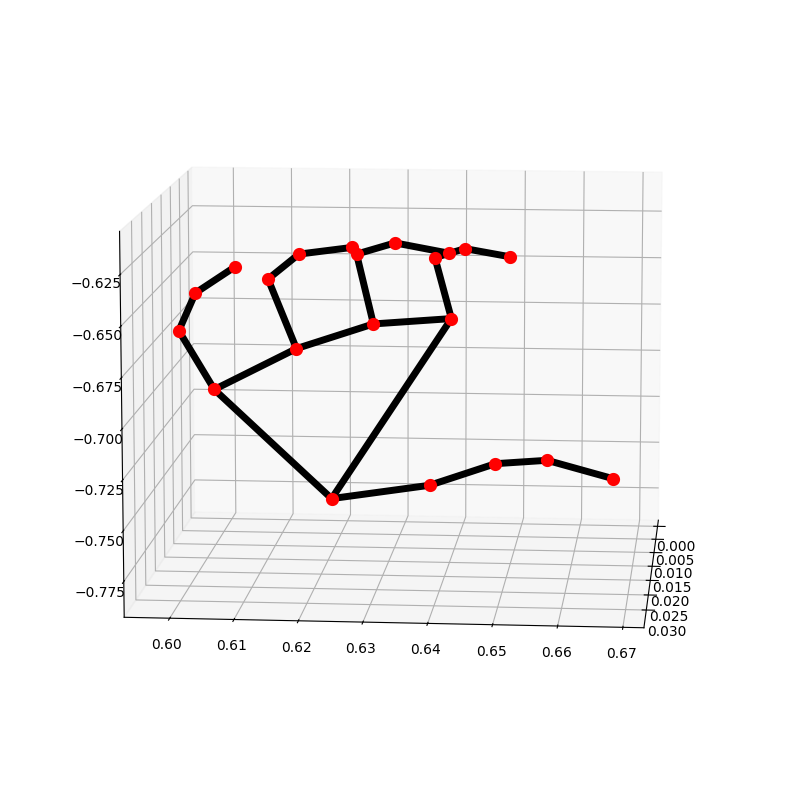

In [28]:
# Convert to Protobuf
lhand_lms = hand_tensor_to_normalized_landmark_list(lhand_test_frame)
mp_drawing.plot_landmarks(lhand_lms, mp_hands.HAND_CONNECTIONS, azimuth=5)

## Plotting Two Hands

Now time for a second exercise! Let's see if we can plot two hands at once (with elbows ideally). This will require generating a new `connections` list which the `plot_landmarks` function will use for determining when/where to draw lines. If we write a simple map function on the original set of tuples (that just increments all start and end hand landmarks by some amount), then for the input landmarks just append the left hand and right hand landmarks we should be cooking with gas.

[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


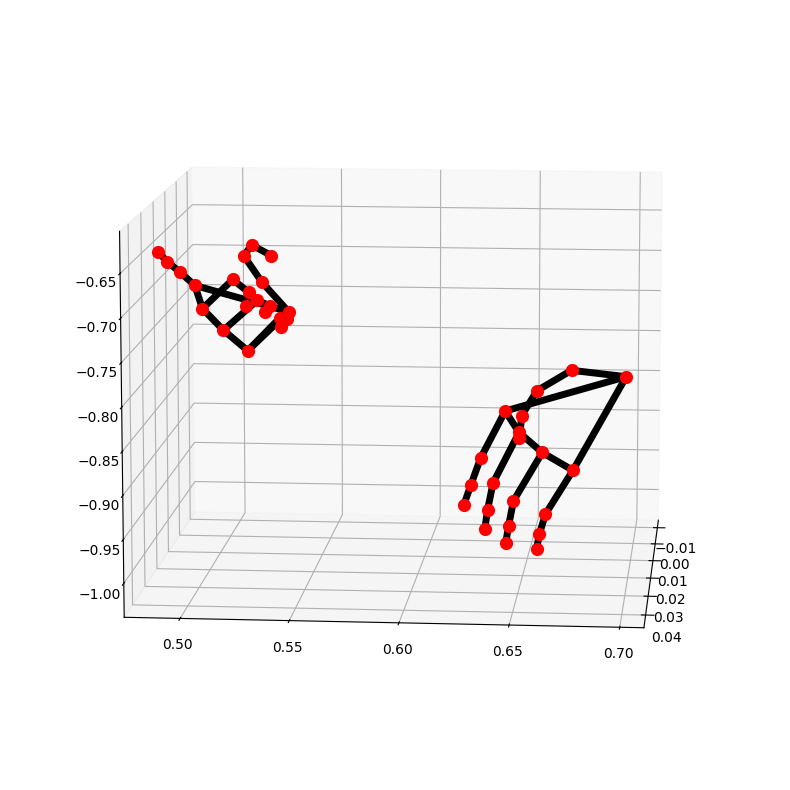

In [99]:
def plot_reduced_two_hands(reduced_data: torch.Tensor):
    """
    Plot the landmarks of two hands from a given reduced_data frame.
    """
    # Should be a single frame
    assert reduced_data.ndim == 1
    assert reduced_data.shape[0] == 141

    # Reduce to just the hand positions
    hands = reduced_data[5*3:]

    # Now [0, 21) are lhand lms
    # [21, 42) are rhand lms

    # Convert to landmarks
    hands_lms = tensor_to_normalized_landmark_list(hands)

    rhand_connections = list(map(lambda tup: (tup[0] + NUM_LHAND_LMS, tup[1] + NUM_LHAND_LMS), mp_hands.HAND_CONNECTIONS))
    twohand_connections = list(mp_hands.HAND_CONNECTIONS) + rhand_connections
    # print(twohand_connections)

    # Generate connections. Basically just the concatenation of two lists
    # of tuples, but the right hand just needs to be modified such that all
    # starting and endpoints are incremented by some amount.

    mp_drawing.plot_landmarks(hands_lms, twohand_connections, azimuth=5)

# e.g.: if 12000 is switched for 10000 instead, we see a degenerate case in the model
# where the two hands are too close and the model predicts the same hand shape essentially for both.
plot_reduced_two_hands(reduced_test_data[12000])

## Filtering Data

Attempts at following pre-processing from the paper.

In [78]:
# Create a function that only keeps frames where the wrist is above elbow.
def filter_reduced_to_coding(reduced_data: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Preprocess a reduced form tensor to only contain frames where the right hand wrist
    is above the right elbow. (We assume that the right hand is the dominant signing hand).
    In ASL (and many sign languages) it's common for signs to only take place when the center
    of mass of the dominant hand is above the elbow. We're using wrist as a proxy.

    Returns the filtered frames as well as the mask identifying which frames were valid.
    """
    assert reduced_data.shape[-1] == 141

    # Filter down to frames where the right wrist is above right elbow. Because we're in CV
    # land, smaller Y coordinate is actually further up in frame.
    mask = reduced_data[..., (REDUCED_RWRIST*3)+1] < reduced_data[..., (REDUCED_RELBOW*3)+1]
    # print(f"mask.shape={mask.shape}")
    return reduced_data[mask], mask

result, _ = filter_reduced_to_coding(reduced_test_data)
print(result.shape)

torch.Size([23843, 141])


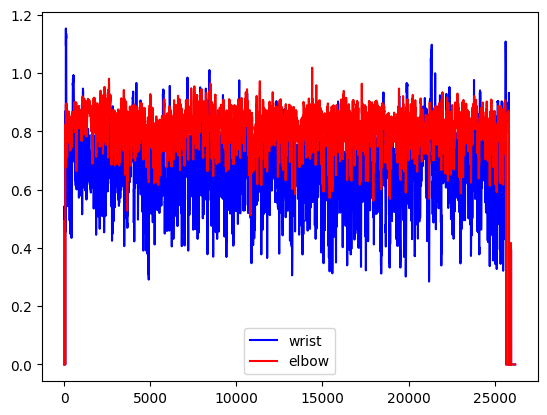

In [61]:
import matplotlib.pyplot as plt

# Let's quickly look at what the right wrist and right elbow heights look like over time:
wrist_heights = reduced_test_data[:, (REDUCED_RWRIST*3) + 1]
elbow_heights = reduced_test_data[:, (REDUCED_RELBOW*3) + 1]

# Something is totally wrong here.
window_start = 0
plt.plot(wrist_heights, color="blue", label="wrist")
plt.plot(elbow_heights, color="red", label="elbow")
plt.legend()
plt.show()

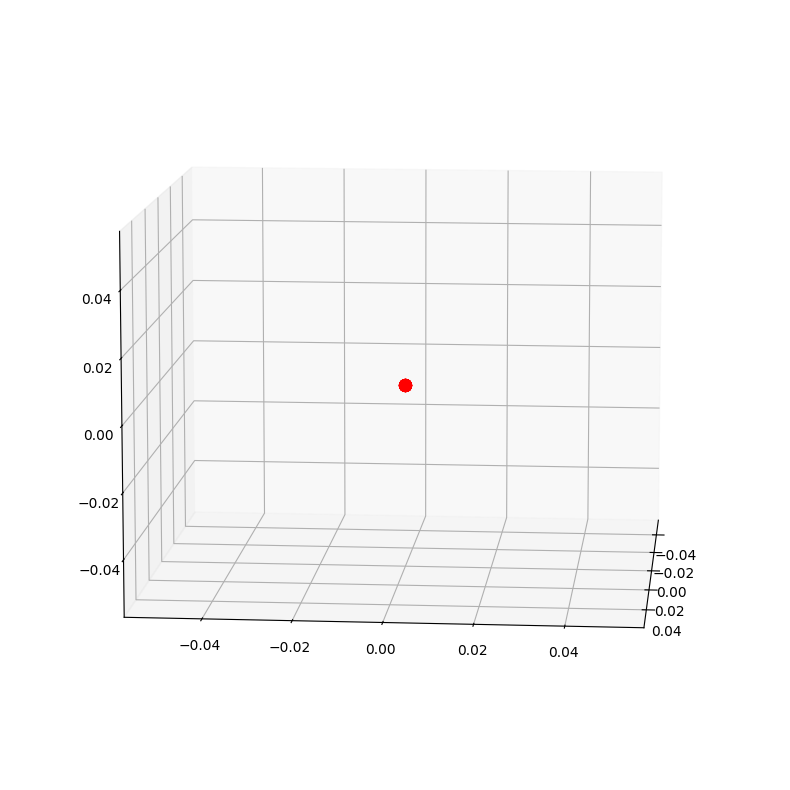

In [54]:
# Note that the way Aragorn's thing is setup it can output garbage data where all coordinates are 0.
plot_hand_tensor(reduced2rhand(result[1000]))

## Plotting Poses

I realized I should plot the pose data so I can understand what the axes we're looking at are.

NOTE: I've discovered that `plot_landmarks` actually negates the y-axis and z-axis sneakily (so that
the pose looks correct when drawn), however that means that these are unreliable for interpreting what's
positive/negative for the axes. Instead here's a summary:
- x grows from left to right in the image. When normalized, 0 is leftmost, 1 is rightmost edge of frame.
- y grows from top row of image to bottom row. 0 is top, 1 is bottom.
- z grows the further away from camera the point is. 0 is camera origin.

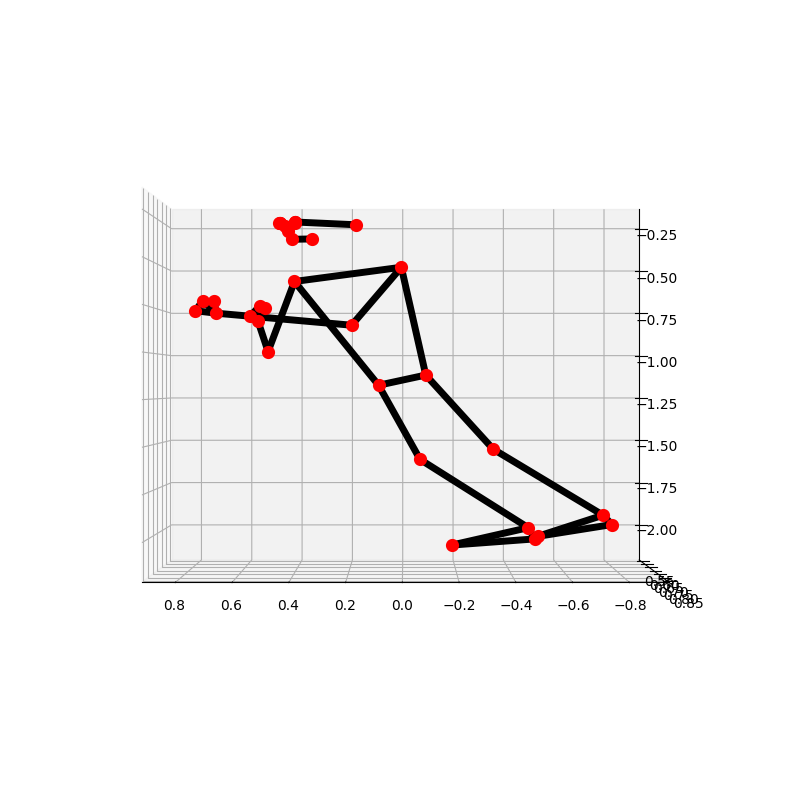

In [81]:
test_frame = test_data[10000]
# The poses are the first 33 points.
pose_frame = test_frame[:33*3]
# Convert to Protobuf
pose_lms = tensor_to_normalized_landmark_list(pose_frame)
# print(pose_lms)
# Plot the stuff
mp_drawing.plot_landmarks(pose_lms, mp_pose.POSE_CONNECTIONS, elevation=0,azimuth=90)

## k-Means Clustering

Writing code that will actually do some clustering. Using this as a reference: ~~https://github.com/Ransaka/GMM-from-scratch~~

Update: going with the `fast_pytorch_kmeans` package instead. [LINK to repo](https://github.com/DeMoriarty/fast_pytorch_kmeans). Super easy to use and fast! We'll make sure to credit them in the report.

In [85]:
from fast_pytorch_kmeans import KMeans

NUM_CLASSES = 1000
kmeans = KMeans(n_clusters=NUM_CLASSES, mode='euclidean', verbose=1)
reduced_data_gpu = reduced_test_data.to(device)
labels = kmeans.fit_predict(reduced_data_gpu)

used 34 iterations (1.9637s) to cluster 26198 items into 1000 clusters


In [102]:
# Sanity checking that classes are all in requested range.
print(labels.min()) # should be 0
print(labels.max()) # should be 1000-1

tensor(0, device='cuda:0')
tensor(999, device='cuda:0')


In [103]:
# Choose members of a given class, and print some members of the frame to see how they look.
def get_class_members(reduced_data: torch.Tensor, labels: torch.LongTensor, class_number: int) -> torch.Tensor:
    """
    Return a tensor containing all of the entries identified as the given class number.

    Args:
        reduced_data (torch.Tensor): Source data. 2D tensor of shape=(num_items,num_features).
        labels (torch.LongTensor): Labels for each of the source data points. shape=(num_items).
        class_number (int): The class number to extract. Should be in range [0, num_classes).

    Returns:
        torch.Tensor: _description_
    """
    assert reduced_data.ndim == 2
    assert labels.ndim == 1
    assert reduced_data.shape[0] == labels.shape[0]

    # Make sure class is a valid label.
    assert class_number in labels

    indices = labels == class_number
    return reduced_data[indices]

# Noticed that class 58 appears a ton at both the beginning and end of our frames. Lets
# examine it.
class_58 = get_class_members(reduced_data_gpu, labels, 58)
print(f"class_58.shape={class_58.shape}")

class_58.shape=torch.Size([517, 141])


Plotting member 208 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


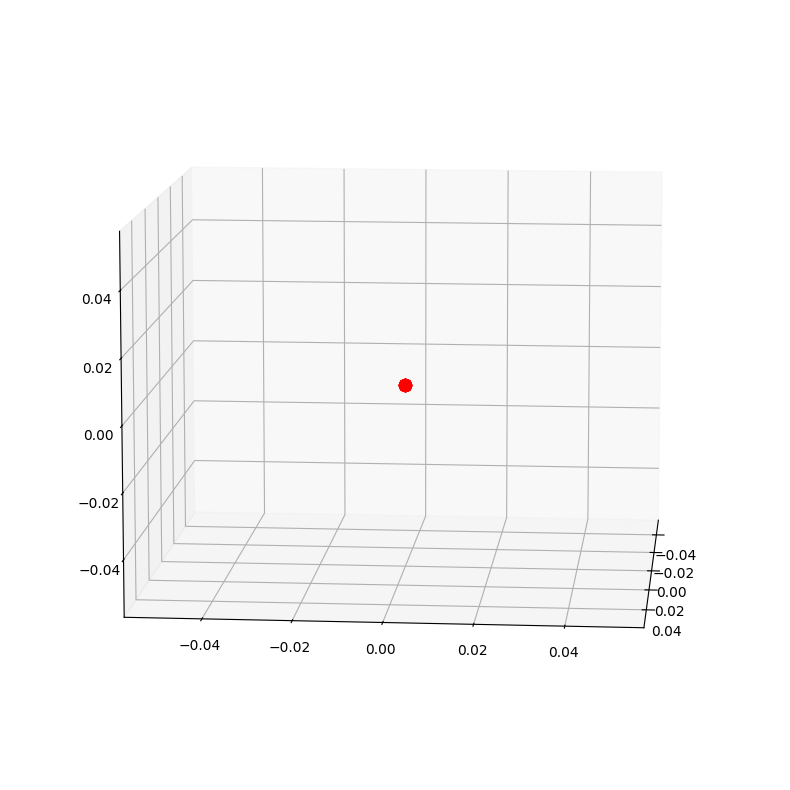

Plotting member 7 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


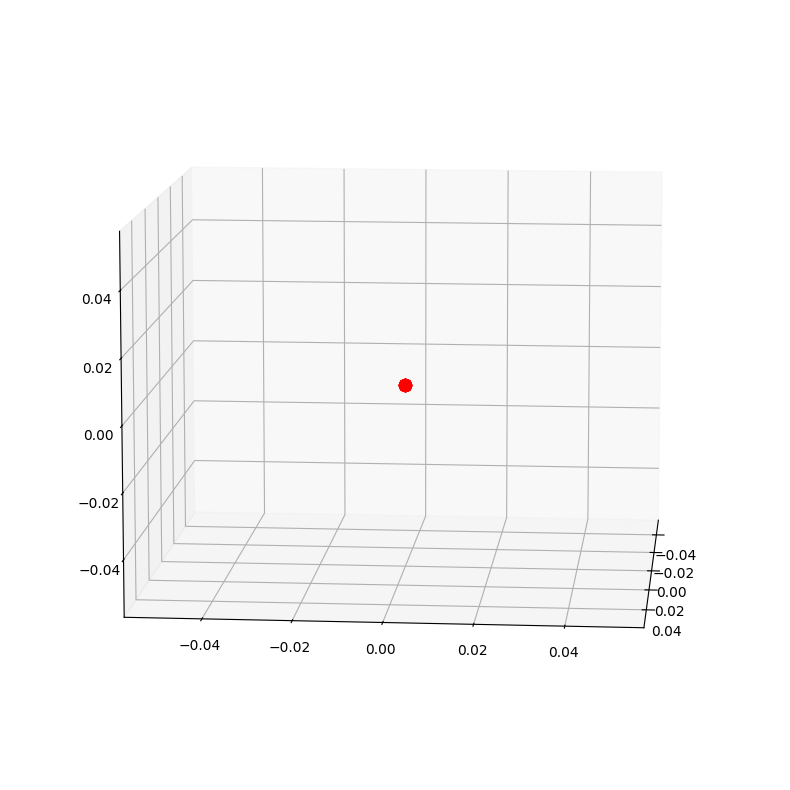

Plotting member 303 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


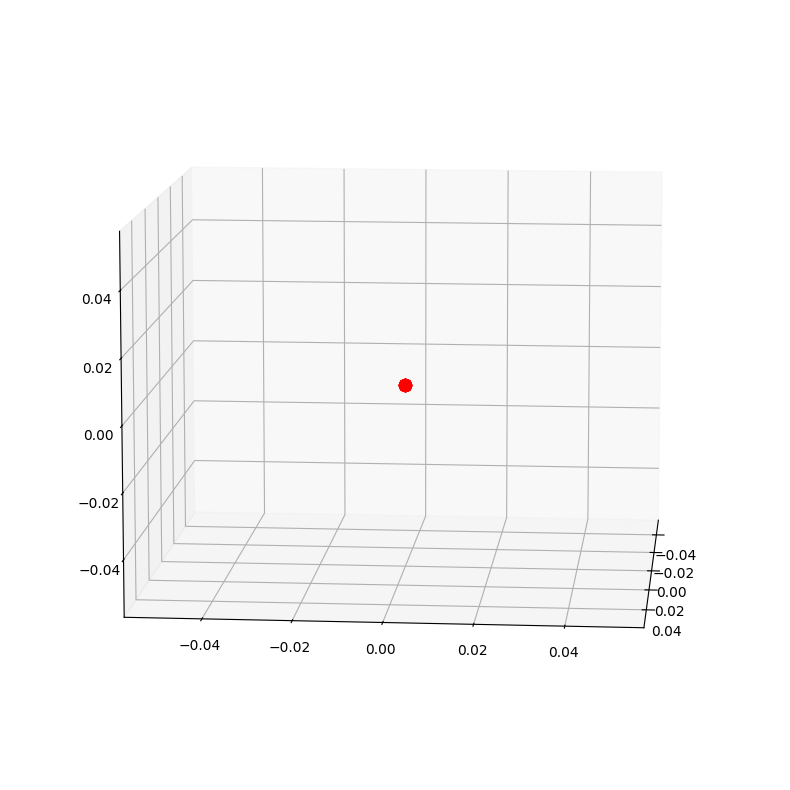

Plotting member 361 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


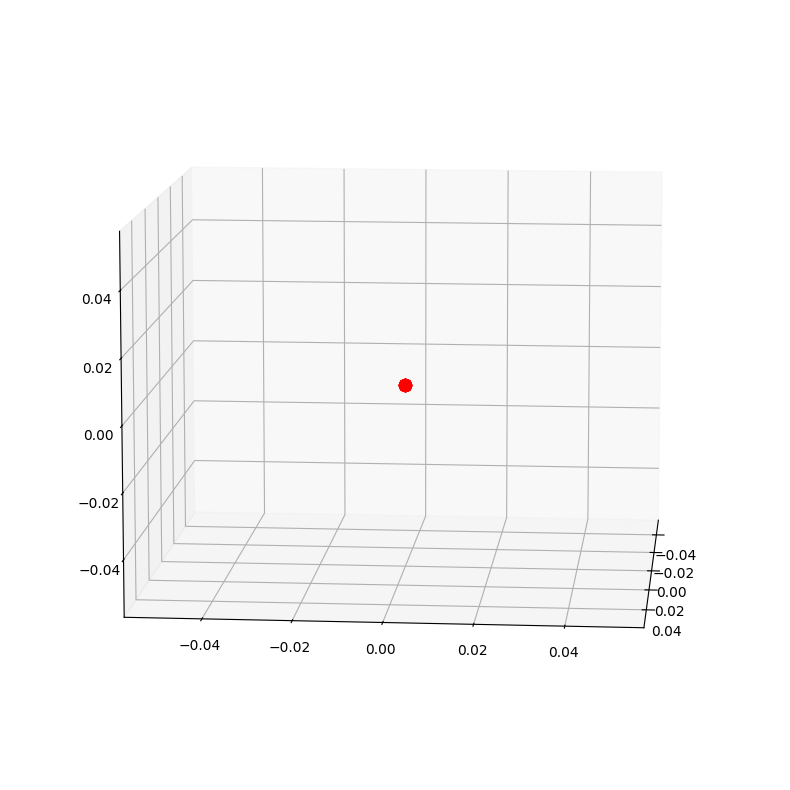

In [115]:
# Take 4 arbitrary members from class 58 and look at them
def plot_rand_members_of_class(class_members: torch.Tensor, k=4):
    """
    Plot the both hands plot of k random members of the given class.

    Args:
        class_members (torch.Tensor): A tensor of "reduced" frames that all
            belong to the same k-means cluster.
        k (int): the number of members to plot from the class.
    """
    # class_members should be a 2D array of shape=(num_members, num_features)
    assert class_members.ndim == 2
    torch.manual_seed(517)
    perm = torch.randperm(class_members.size(0))
    idx = perm[:4]
    samples = class_members[idx]
    for i, sample in enumerate(samples):
        print(f"Plotting member {idx[i]} of class")
        plot_reduced_two_hands(sample)

plot_rand_members_of_class(class_58)

In [107]:
# Look at some other arbitrarily selected classes
torch.manual_seed(529)
classperm = torch.randperm(NUM_CLASSES)
classperm[:3]

tensor([105,  23, 576])

Viewing random members of class 105
Plotting member 18 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


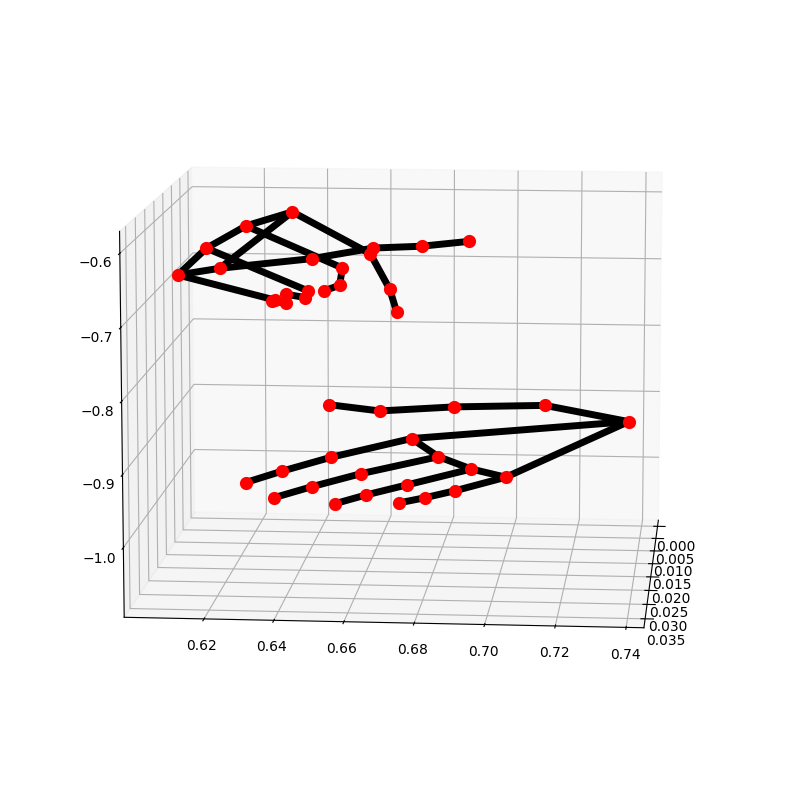

Plotting member 11 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


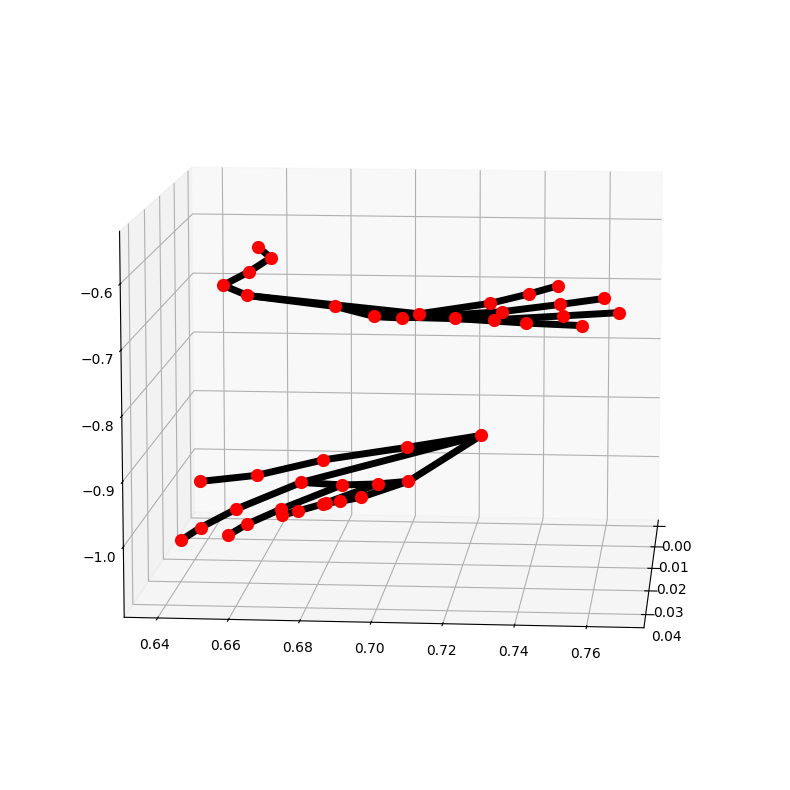

Plotting member 19 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


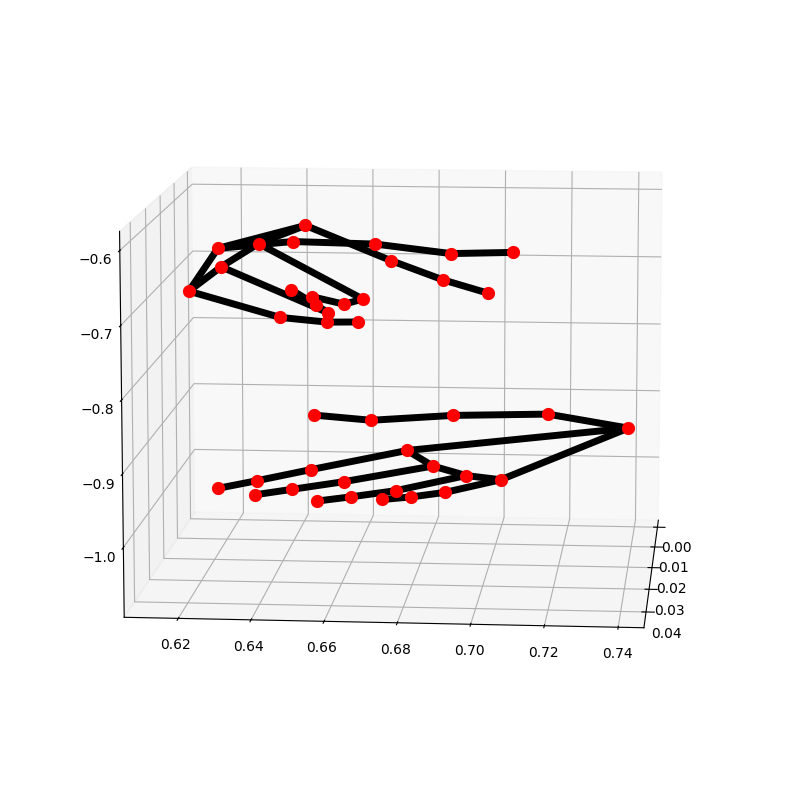

Plotting member 21 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


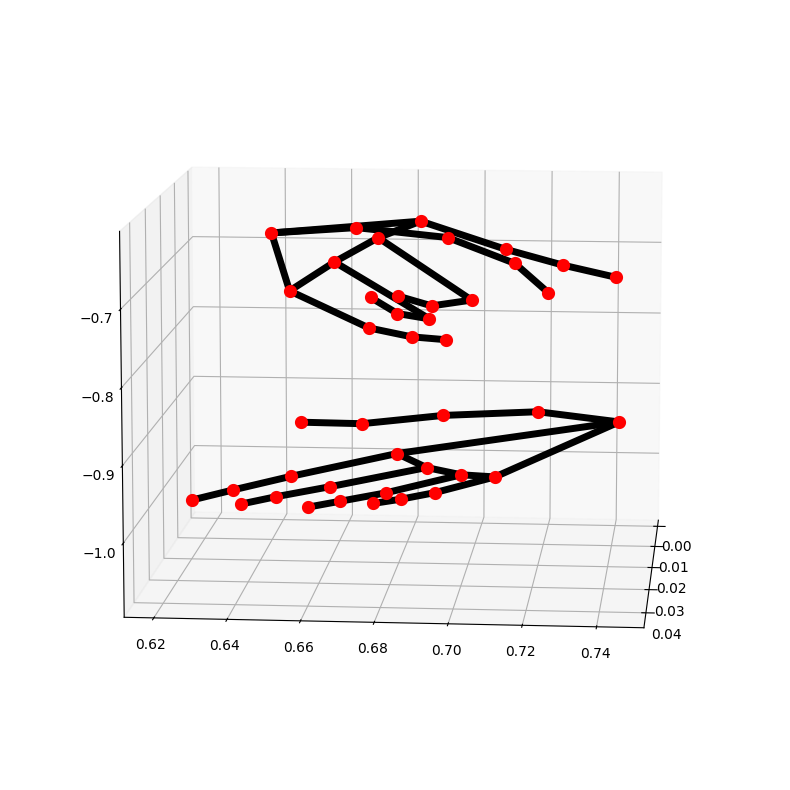

In [116]:
print(f"Viewing random members of class {classperm[0]}")
class_members = get_class_members(reduced_data_gpu, labels, classperm[0])
plot_rand_members_of_class(class_members)

Viewing random members of class 23
class_members.shape=torch.Size([23, 141])
Plotting member 17 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


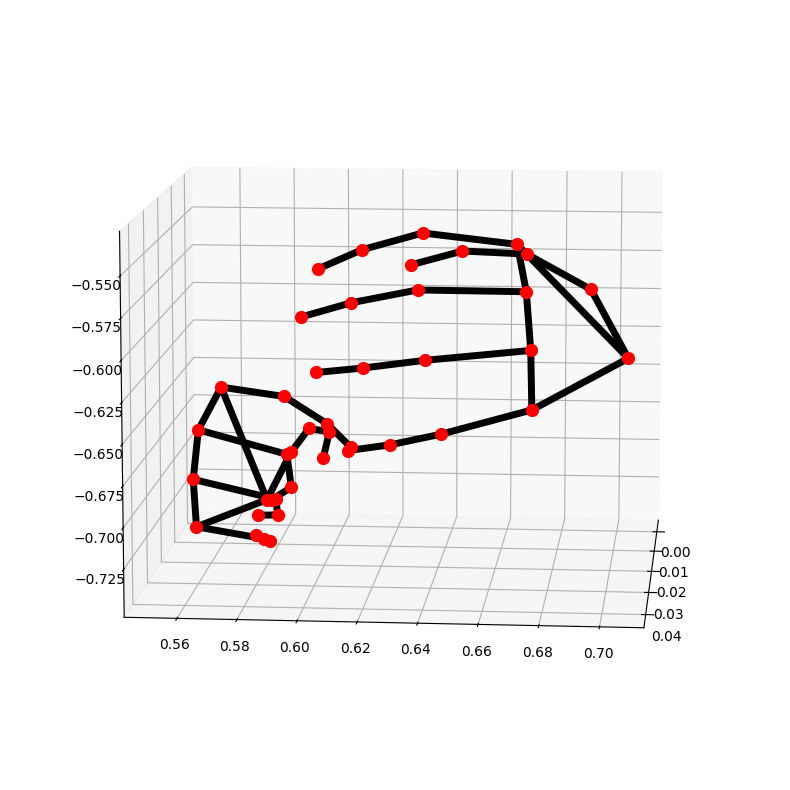

Plotting member 15 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


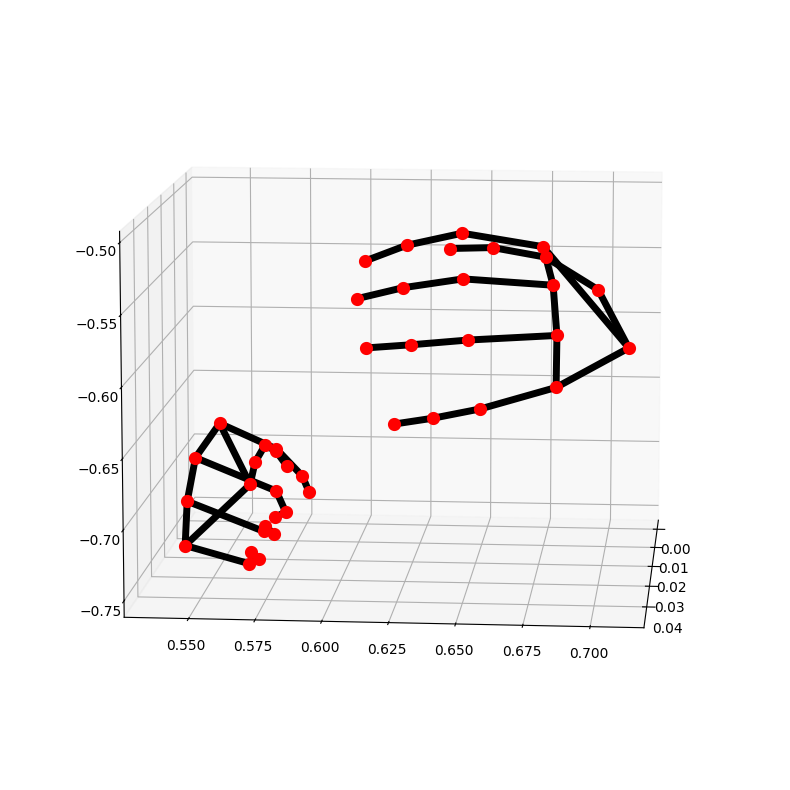

Plotting member 19 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


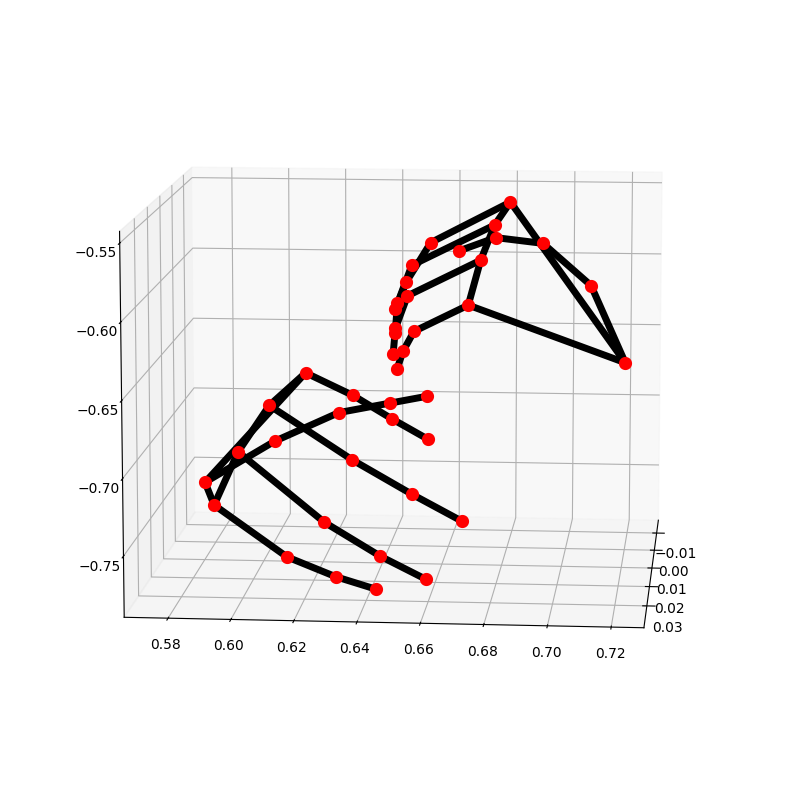

Plotting member 5 of class
[(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8), (24, 25), (21, 26), (38, 39), (21, 38), (34, 35), (34, 38), (39, 40), (26, 27), (26, 30), (35, 36), (21, 22), (30, 31), (22, 23), (30, 34), (31, 32), (40, 41), (27, 28), (36, 37), (23, 24), (32, 33), (28, 29)]


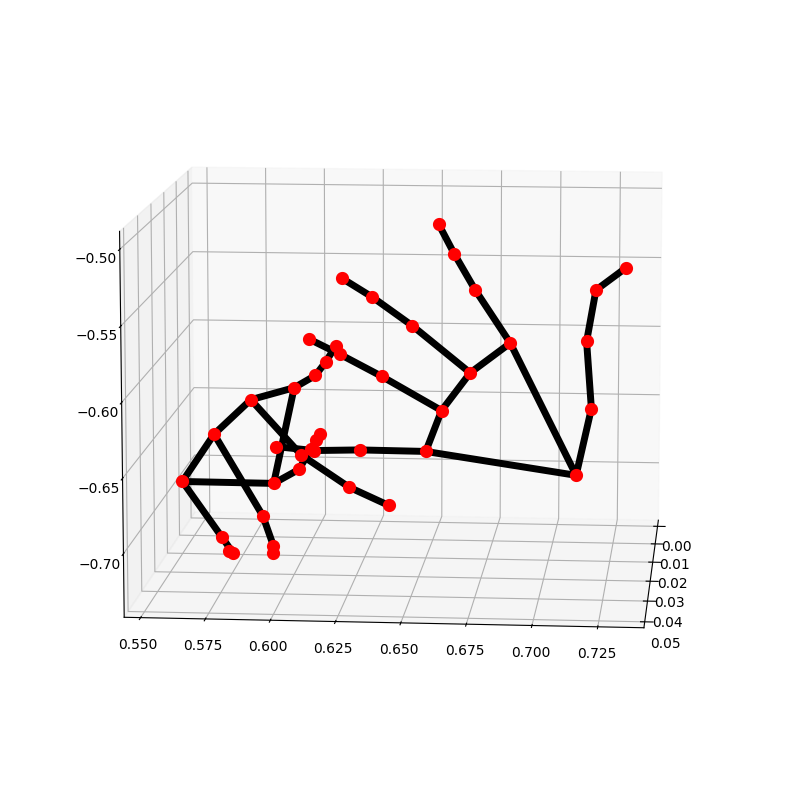

In [118]:
print(f"Viewing random members of class {classperm[1]}")
class_members = get_class_members(reduced_data_gpu, labels, classperm[1])
print(f"class_members.shape={class_members.shape}")
plot_rand_members_of_class(class_members)